In [7]:
import numpy as np
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3 # Clase para trabajar con matrices de transformación homogénea

In [8]:
# --- 1. PARÁMETROS DEL ROBOT Y MODELO DH CON RTB ---
# Definición de las constantes geométricas del manipulador RRR.
# Estas longitudes son parámetros fijos en el modelo de Denavit-Hartenberg (DH) que utilizaremos para configurar el robot en `roboticstoolbox`.

# Parámetros de longitudes de los eslabones
L1 = 10  # Parámetro d₁: traslación a lo largo de Z₀.
L2 = 12  # Parámetro a₂: traslación a lo largo de X₁.
L3 = 8   # Parámetro a₃: traslación a lo largo de X₂.

# Creación de los eslabones del robot usando RevoluteDH
# Los argumentos para RevoluteDH son: (d, a, alpha)
# 'theta' es la variable de la articulación y se pasa en las funciones de cinemática.

# Eslabón 1: Junta de rotación en Z. Traslación d=L1 a lo largo del eje Z₀.
#            Rotación α=90° alrededor de X₀ para alinear Z₀ con Z₁.
#            Corresponde a la transformación de S₀ a S₁.
# El parámetro 'd' en RevoluteDH es para la traslación a lo largo del eje Z del sistema de coordenadas anterior.
eslabon1 = RevoluteDH(d=L1, a=0, alpha=np.pi/2)

# Eslabón 2: Junta de rotación. Traslación a=L2 a lo largo de X₁.
#            Sin traslación d o rotación α adicional (alpha=0).
#            Corresponde a la transformación de S₁ a S₂.
eslabon2 = RevoluteDH(d=0, a=L2, alpha=0)

# Eslabón 3: Junta de rotación. Traslación a=L3 a lo largo de X₂.
#            Sin traslación d o rotación α adicional (alpha=0).
#            Corresponde a la transformación de S₂ a S₃ (efector final).
eslabon3 = RevoluteDH(d=0, a=L3, alpha=0)

# Crear el modelo del robot RRR (3-GDL) a partir de la secuencia de eslabones
robot_3dof = DHRobot([eslabon1, eslabon2, eslabon3], name='Brazo_RRR_3GDL_RTB')

# Opcional: Imprimir una representación textual del modelo del robot
# Esto muestra los parámetros DH configurados en el modelo de RTB.
print("--- Modelo del Brazo RRR (3-GDL) con RTB ---")
print(robot_3dof)

--- Modelo del Brazo RRR (3-GDL) con RTB ---
DHRobot: Brazo_RRR_3GDL_RTB, 3 joints (RRR), dynamics, standard DH parameters
┌─────┬────┬────┬───────┐
│ θⱼ  │ dⱼ │ aⱼ │  ⍺ⱼ   │
├─────┼────┼────┼───────┤
│  q1 │ 10 │  0 │ 90.0° │
│  q2 │  0 │ 12 │  0.0° │
│  q3 │  0 │  8 │  0.0° │
└─────┴────┴────┴───────┘

┌──┬──┐
└──┴──┘



In [9]:
# --- 2. FUNCIONES DE VISUALIZACIÓN PERSONALIZADA ---

def plot_arm(joint_positions, target=None):
    """
    Genera una representación gráfica de la configuración cinemática del robot
    en un espacio cartesiano 3D para la validación visual de los resultados.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    points = np.array(joint_positions)
    # Dibujo de la cadena cinemática (eslabones y articulaciones)
    ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', color='purple', lw=4, label='Eslabones', zorder=1)
    ax.scatter(points[:-1, 0], points[:-1, 1], points[:-1, 2], c='blue', s=100, label='Articulaciones', zorder=2)
    # Representación visual de la articulación final y el punto objetivo
    final_joint = points[-1]
    ax.scatter(final_joint[0], final_joint[1], final_joint[2], s=350, facecolors='none', edgecolors='darkviolet', lw=2, zorder=4)
    if target is not None:
        ax.scatter(target[0], target[1], target[2], c='gold', s=250, marker='*', label='Objetivo', zorder=3, edgecolor='black')
    # Configuración del entorno gráfico
    ax.set_xlabel('Eje X (m)'), ax.set_ylabel('Eje Y (m)'), ax.set_zlabel('Eje Z (m)')
    ax.set_title('Simulador Robótico 3-DOF (Enfoque Matricial DH)')
    max_range = L1 + L2 + L3
    ax.set_xlim([-max_range, max_range]), ax.set_ylim([-max_range, max_range]), ax.set_zlim([0, max_range])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels), ax.grid(True)
    plt.show()

--- RESULTADO CINEMÁTICA DIRECTA ---
Para los ángulos articulares: [ 40  60 -50]°
La posición cartesiana del efector final es: (x=10.632, y=8.921, z=21.781)

--- VISUALIZACIÓN DE CINEMÁTICA DIRECTA ---


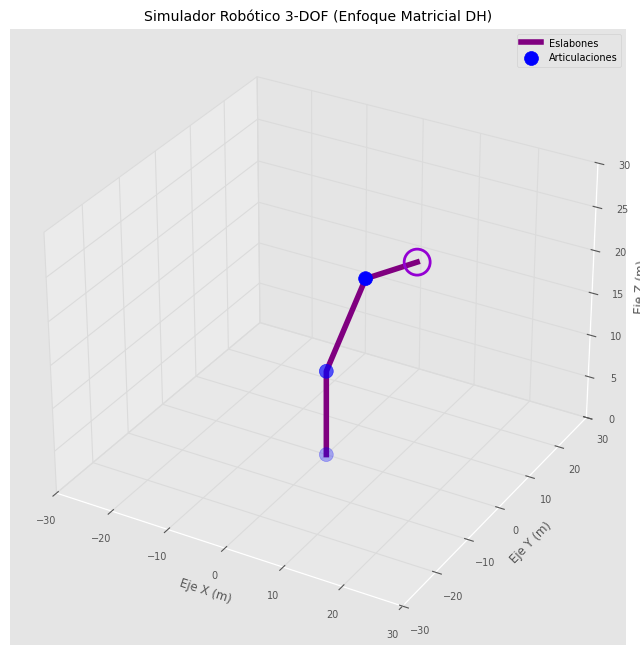



--- RESULTADO CINEMÁTICA INVERSA ---
Para la posición objetivo: (x=10.632, y=8.921, z=21.781)
Los ángulos articulares calculados son: (θ1=40.000°, θ2=60.000°, θ3=-50.000°)
VERIFICACIÓN: La posición alcanzada es (x=10.632, y=8.921, z=21.781)

--- VISUALIZACIÓN DE CINEMÁTICA INVERSA - VERIFICACIÓN ---


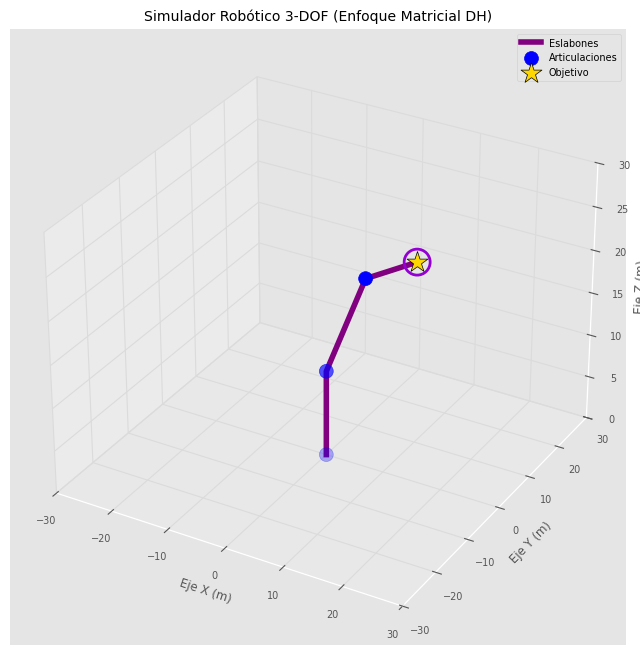

In [10]:
# --- 3. EJECUCIÓN Y VALIDACIÓN ALGORÍTMICA ---

# Definición de Ángulos de Prueba:
# Se proporciona un vector de configuración articular $ \Theta = [\theta_1, \theta_2, \theta_3] $ para
# los cálculos de cinemática directa.
angles_deg = np.array([40, 60, -50])
angles_rad = np.deg2rad(angles_deg)

# --- Prueba del Problema Cinemático Directo (PCD) ---
# Teoría Matemática con RTB (Cinemática Directa):
# `roboticstoolbox` utiliza internamente el formalismo de Denavit-Hartenberg para calcular las matrices de transformación homogénea entre sistemas de coordenadas de eslabones consecutivos. El método `fkine()` (forward kinematics) compone estas matrices secuencialmente para obtener la pose (posición y orientación) del efector final con respecto al sistema de coordenadas base.
#
# $ T_N^0 = T_1^0(q_1) \cdot T_2^1(q_2) \cdot \dots \cdot T_N^{N-1}(q_N) $
#
# Donde $ T_i^{i-1} $ es la matriz de transformación homogénea del sistema de coordenadas $ S_i $ con respecto a $ S_{i-1} $, que depende del ángulo de la articulación $ q_i $.

# Calcular la cinemática directa (PCD) con el modelo RTB
# `fkine()` retorna un objeto `spatialmath.SE3` que contiene la matriz de transformación.
# La posición cartesiana está en el atributo `.t` del objeto SE3.
T_final_fkine = robot_3dof.fkine(angles_rad)

# Mostrar la matriz de transformación homogénea y la posición cartesiana
print("--- RESULTADO CINEMÁTICA DIRECTA ---")
print(f"Para los ángulos articulares: {angles_deg}°")
final_pos_fkine = T_final_fkine.t
print(f"La posición cartesiana del efector final es: (x={final_pos_fkine[0]:.3f}, y={final_pos_fkine[1]:.3f}, z={final_pos_fkine[2]:.3f})")

# --- VISUALIZACIÓN DE CINEMÁTICA DIRECTA ---

# Para replicar la visualización de `matrix-approach`, utilizaremos la función `plot_arm`
# que hemos definido en este mismo script.
# Necesitamos obtener las posiciones de todas las articulaciones, ya que `fkine()` solo
# devuelve la pose del efector final. Reconstruimos las posiciones intermedias de cada articulación
# usando el método `.A()` de cada eslabón y componiendo las transformaciones.

# Reconstruir las posiciones de las articulaciones para plot_arm
# P₀: Origen del sistema de referencia inercial S₀.
p0 = np.array([0, 0, 0])

# P₁: Posición de la articulación 1 (Hombro).
# Teoría: Se calcula mediante la transformación del primer eslabón a partir del ángulo θ1.
T_0_1_joint = eslabon1.A(angles_rad[0]) # Matriz de transformación T₀¹ para la junta 1
p1 = T_0_1_joint.t # Vector de traslación de la junta 1

# P₂: Posición de la articulación 2 (Codo).
# Teoría: Se calcula componiendo las transformaciones de S₀ a S₁ y de S₁ a S₂.
T_0_2_joint = eslabon1.A(angles_rad[0]) @ eslabon2.A(angles_rad[1])
p2 = T_0_2_joint.t # Vector de traslación de la junta 2

# P₃: Posición del efector final (Pinza).
# Teoría: Se calcula componiendo las transformaciones de S₀ a S₂, y de S₂ a S₃.
T_0_3_joint = eslabon1.A(angles_rad[0]) @ eslabon2.A(angles_rad[1]) @ eslabon3.A(angles_rad[2])
p3 = T_0_3_joint.t # Vector de traslación de la junta 3 (efector final)

all_joints_rtb = [p0, p1, p2, p3]

print("\n--- VISUALIZACIÓN DE CINEMÁTICA DIRECTA ---")
plot_arm(all_joints_rtb)

print("\n" + "="*50 + "\n") # Separador para simular la salida de tu notebook

# --- Prueba del Problema Cinemático Inverso (PCI) ---
# Se utiliza el vector P previamente calculado como el punto objetivo para el PCI.
# Se especifica una configuración de codo para resolver la ambigüedad del PCI.
# El resultado, $ \Theta' $, debe ser matemáticamente idéntico al $ \Theta $ original para demostrar
# la consistencia y correctitud del modelo cinemático.

# Teoría Matemática con RTB (Cinemática Inversa):
# `robotics-toolbox` proporciona solvers de cinemática inversa (ej. `ikine_LM` para Levenberg-Marquardt). Estos solvers, a menudo numéricos, buscan los ángulos articulares $ \Theta' $ que resultan en una pose del efector final $ T_{objetivo} $.
#
# Para este robot RRR, el PCI puede tener múltiples soluciones. Los solvers numéricos requieren una `q0` (configuración inicial) para guiar la búsqueda de la solución y converger a una de las posibles configuraciones (e.g., "codo arriba" o "codo abajo").
#
# Se utiliza la posición $ P $ obtenida del PCD como el objetivo para verificar la consistencia y exactitud del algoritmo de cinemática inversa. El PCI debe encontrar un vector de configuración $ \Theta' $ que sea idéntico al $ \Theta $ original (o una de sus soluciones válidas).

# La posición objetivo para la cinemática inversa será la que obtuvimos del PCD
target_pose_ikine = T_final_fkine # Objeto SE3

print("--- RESULTADO CINEMÁTICA INVERSA ---")
print(f"Para la posición objetivo: (x={target_pose_ikine.t[0]:.3f}, y={target_pose_ikine.t[1]:.3f}, z={target_pose_ikine.t[2]:.3f})")

q_calculado_ikine = robot_3dof.ikine_LM(target_pose_ikine, q0=angles_rad, mask=[1,1,1,0,0,0])

if q_calculado_ikine.success:
    # `result_ikine.q` contiene el array de ángulos articulares en radianes
    target_angles_rad_ikine = q_calculado_ikine.q
    target_angles_deg_ikine = np.rad2deg(target_angles_rad_ikine)
    print(f"Los ángulos articulares calculados son: (θ1={target_angles_deg_ikine[0]:.3f}°, θ2={target_angles_deg_ikine[1]:.3f}°, θ3={target_angles_deg_ikine[2]:.3f}°)")

    # Verificación final: Se aplica la PCD a los ángulos resultantes de la PCI.
    # Esto confirma que los ángulos calculados por la cinemática inversa
    # realmente llevan el efector final a la posición objetivo.
    T_verificacion_ikine = robot_3dof.fkine(target_angles_rad_ikine)
    final_pos_verificacion_ikine = T_verificacion_ikine.t

    print(f"VERIFICACIÓN: La posición alcanzada es (x={final_pos_verificacion_ikine[0]:.3f}, y={final_pos_verificacion_ikine[1]:.3f}, z={final_pos_verificacion_ikine[2]:.3f})")

    # --- VISUALIZACIÓN DEL ROBOT (CONFIGURACIÓN INVERSA Y VERIFICACIÓN) ---
    # Se visualiza el robot en la configuración de ángulos obtenida de la cinemática inversa.
    # Esto valida visualmente que el robot puede alcanzar la posición objetivo con los ángulos calculados.
    print("\n--- VISUALIZACIÓN DE CINEMÁTICA INVERSA - VERIFICACIÓN ---")

    # Reconstruir las posiciones de las articulaciones con los ángulos calculados por IK.
    # P₀: Origen del sistema de referencia inercial S₀.
    p0_ik = np.array([0, 0, 0])

    # P₁: Posición de la articulación 1 (Hombro).
    T_0_1_ik_joint = eslabon1.A(target_angles_rad_ikine[0])
    p1_ik = T_0_1_ik_joint.t

    # P₂: Posición de la articulación 2 (Codo).
    T_0_2_ik_joint = eslabon1.A(target_angles_rad_ikine[0]) @ eslabon2.A(target_angles_rad_ikine[1])
    p2_ik = T_0_2_ik_joint.t

    # P₃: Posición del efector final (Pinza).
    T_0_3_ik_joint = eslabon1.A(target_angles_rad_ikine[0]) @ eslabon2.A(target_angles_rad_ikine[1]) @ eslabon3.A(target_angles_rad_ikine[2])
    p3_ik = T_0_3_ik_joint.t

    all_joints_ik_rtb = [p0_ik, p1_ik, p2_ik, p3_ik]

    plot_arm(all_joints_ik_rtb, target=final_pos_fkine) # Pasamos el objetivo original para que aparezca la estrella

else:
    print("No se encontró una solución para la cinemática inversa con la configuración objetivo dada.")